# Probabilistic Age Estimation

In this NB we develop a CNN which can take images of faces and outputs a CPD, which is here a conditional Gaussian distribution, that assignes to each possible age a likelihood. 

## Installing TensorFlow and Keras

The deep learning packages, TensorFlow and Keras are not installed by default, but can be installed as follows:

In [1]:
COLAB = FALSE
KAGGLE = TRUE

In [2]:
#Installing TF and Keras takes approx 2 minutes
if (COLAB){
    ptm <- proc.time()
    install.packages("tensorflow")
    install.packages("keras")
    install.packages("tfprobability") #needs approx 30 seconds
    proc.time() - ptm
    #devtools::install_github("rstudio/keras") works ok but no tfp
}
if (KAGGLE){
   reticulate::use_condaenv("r-reticulate", required = TRUE) #We activate the conda enviroment
   reticulate::py_install('tensorflow_probability==0.14.1', pip=TRUE, envname="r-reticulate") #Installs the correct python version of TFP
   install.packages("tfprobability") #This installs the R-wrappers of TFP
}

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [24]:
library(keras)
library(tensorflow)
library(tfprobability)
library(tidyverse)
library(imager)#for loading images
d = tf$version
d$VERSION #2.6.5
tf$test$gpu_device_name() #If '/device:GPU:0' then the on GPU

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
✔ purrr   0.3.4      
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ imager::add()       masks magrittr::add()
✖ stringr::boundary() masks imager::boundary()
✖ tidyr::extract()    masks magrittr::extract()
✖ tidyr::fill()       masks imager::fill()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()
✖ purrr::set_names()  masks magrittr::set_names()


[1] "2.6.5"

[1] "/device:GPU:0"

## Data loading
In this notebook, you will work with the UTKFace dataset. The data set has been created from the aligned and croped files from: https://susanqq.github.io/UTKFace/. Three images with missing ethnicity information has been removed. The dateset was then split into the training, validation and testing set. Executing the following cell will download and unpack the images.

### Preprocessed Data File

#### Manual down and uploading
You can download the preprocessed data file from https://bwsyncandshare.kit.edu/s/pndW4QTkaDTqCzA/download then you can upload the file using the Kaggle upload (see slides)

In [3]:
dir('../input/ukface-split/')

[1] "ukface_split.tgz"

In [5]:
system("tar xvzf ../input/ukface-split/ukface_split.tgz") #Unpacking the images in working dir ~10-30 sec

In [6]:
dir() #There should be test, train, valid

[1] "__notebook_source__.ipynb" "test"                     
[3] "train"                     "valid"

In [7]:
list.files('valid/')[1:10]
# The file names code age ...

[1] "1_0_0_20161219140627985.jpg.chip.jpg"
 [2] "1_0_0_20161219161028662.jpg.chip.jpg"
 [3] "1_0_0_20161219191041403.jpg.chip.jpg"
 [4] "1_0_0_20161219203503252.jpg.chip.jpg"
 [5] "1_0_0_20161219212921070.jpg.chip.jpg"
 [6] "1_0_0_20170109191808532.jpg.chip.jpg"
 [7] "1_0_0_20170110212623527.jpg.chip.jpg"
 [8] "1_0_0_20170110212704144.jpg.chip.jpg"
 [9] "1_0_0_20170110213005631.jpg.chip.jpg"
[10] "1_0_0_20170110213011627.jpg.chip.jpg"

## Data Preperation

We translate the images in Tensors and extract the age from the filename. Takes about 2-3 to run.


In [15]:
image_size = 64L
PATH = 'valid/'
load_data = function(PATH = 'valid/'){
  files = dir(PATH, pattern = '.jpg')
  y = rep(-1,length(files))
  for (i in 1:length(files)){
    y[i] = as.numeric(strsplit(files[i], '_')[[1]][1])  #Age
  }
  X_train = array(dim=c(length(files), image_size,image_size,3L))
  loaded = 0
  for (i in 1:length(files)){
      #try({ #Few (or only 1) files cause an exeption, just ignore it
        img <- keras::image_load(paste0(PATH,files[i]), target_size = c(image_size,image_size))
        x <- keras::image_to_array(img)
        X_train[i,,,] = x
        loaded = loaded + 1
      #})
      if (i %% 100 == 0) cat(i)
    }
  return (list(X=X_train, y=y))
}
d = load_data('valid/')
X_valid = d$X
y_valid = d$y

d = load_data('test/')
X_test = d$X
y_test = d$y

d = load_data('train/')
X_train = d$X
y_train = d$y

1002003004005006007008009001000110012001300140015001600170018001900200021002200230010020030040050060070080090010001100120013001400150016001700180019002000210022002300100200300400500600700800900100011001200130014001500160017001800190020002100220023002400250026002700280029003000310032003300340035003600370038003900400041004200430044004500460047004800490050005100520053005400550056005700580059006000610062006300640065006600670068006900700071007200730074007500760077007800790080008100820083008400850086008700880089009000910092009300940095009600970098009900100001010010200103001040010500106001070010800109001100011100112001130011400115001160011700118001190012000121001220012300124001250012600127001280012900130001310013200133001340013500136001370013800139001400014100142001430014400145001460014700148001490015000151001520015300154001550015600157001580015900160001610016200163001640016500166001670016800169001700017100172001730017400175001760017700178001790018000181001820018300184001850018600187001880018

Let's have a first look on our data. First visualize a face image from the train data set.


Attaching package: ‘grid’


The following object is masked from ‘package:imager’:

    depth




[1] 52

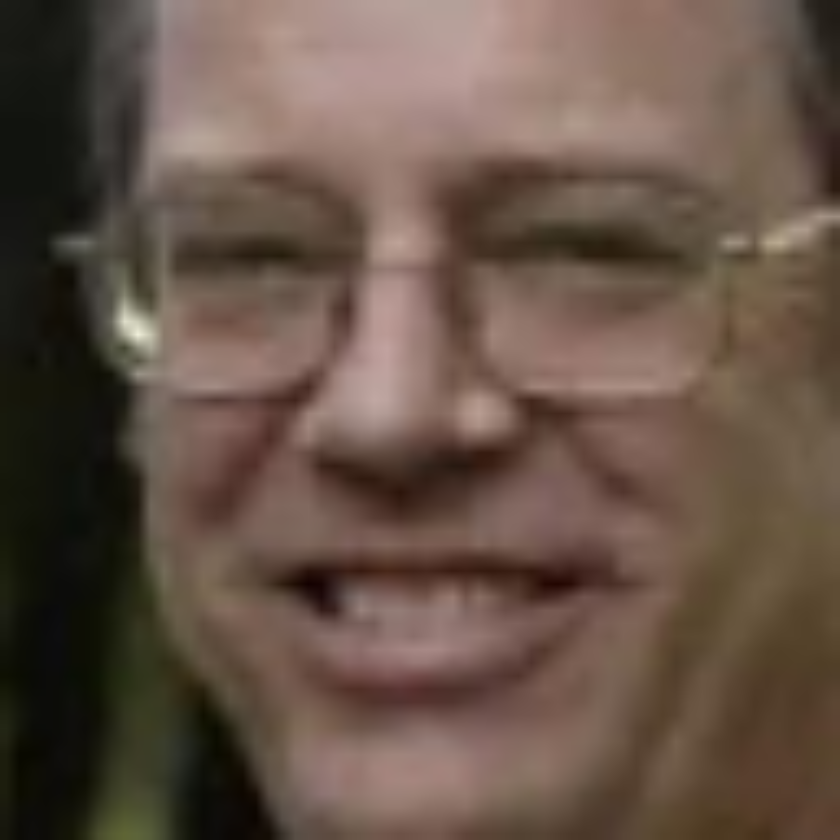

In [16]:
library(grid)
idx = 15000
grid.raster(X_train[idx,,,]/255) #Check an image 
y_train[idx]

In [17]:
summary(X_test) #We should have values from 0 to 255 (no normalization has been done)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0    72.0   123.0   122.9   173.0   255.0 

Let's have on distribution of ages in the train, validation, and test data set. 

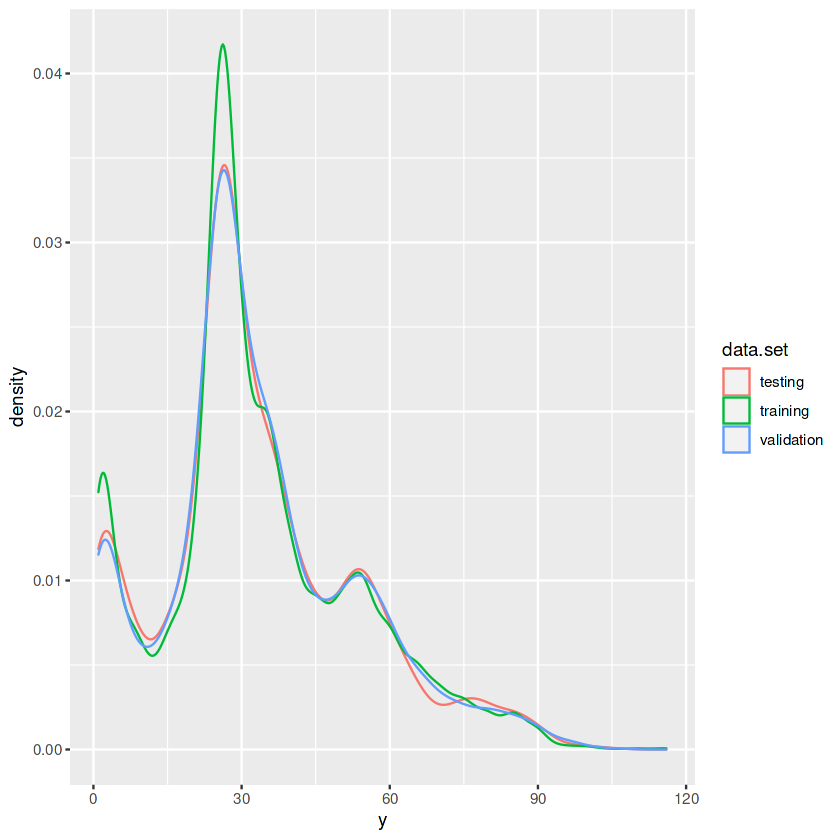

In [18]:
library(ggplot2)
df = data.frame(y=y_train, data.set = 'training')
df = rbind(df, data.frame(y=y_test, data.set = 'testing'))
df = rbind(df, data.frame(y=y_valid, data.set = 'validation'))
ggplot(df) + geom_density(aes(x=y, color=data.set))

## Fit a regression model a variable variance 

Now we want to set up a NN that takes in face images and predict CPDs for the age.  As CPD we want to Gaussians where both parameters $\mu$ and $\sigma(x)$ are allowed to depend on x. Therefore, we define two heads, one controlling $\sigma$ and one $\mu$.



In [21]:
CPD = function(out){
  mu = k_softplus(out[, 1, drop=FALSE]) #Need to be positive as well
  s =  0.5 + k_softplus(out[, 2, drop=FALSE]) #Need to be positive and larger 0
  return (tfd_normal(loc = mu, scale = s))
}

Now we define a CNN which takes the images and learns how to extract useful image-feature that help for the age prediction task. After the flattening these features are used in the fully connected part to predict an appropriate Gaussian CPD.

**Question**
* How many weights do we have in our NN?
* How many features are extracted by the convolutional part?


In [27]:
# Image model
img_train <- X_train[[1]]
dropout_rate = 0.3
model <-  keras_model_sequential() %>%
  
  ### First Block
  layer_conv_2d(filters = 16, kernel_size = c(3, 3), activation = "relu",
      input_shape = dim(img_train)[-1L], padding = "same") %>%
  #layer_dropout(dropout_rate) %>% 
  layer_conv_2d(filters = 16, kernel_size = c(3, 3), activation = "relu",
                padding = "same") %>%
  #layer_dropout(dropout_rate) %>% 
  layer_max_pooling_2d(pool_size = c(2, 2)) %>%
  
  ### Second Block
  layer_conv_2d(filters = 32, kernel_size = c(3, 3), activation = "relu",
                padding = "same") %>%
  #layer_dropout(dropout_rate) %>% 
  layer_conv_2d(filters = 32, kernel_size = c(3, 3), activation = "relu",
                padding = "same") %>%
  #layer_dropout(dropout_rate) %>% 
  layer_max_pooling_2d(pool_size = c(2, 2)) %>%
  
  ### Third Block
  layer_conv_2d(filters = 64, kernel_size = c(3, 3), activation = "relu",
                padding = "same") %>%
  layer_conv_2d(filters = 64, kernel_size = c(3, 3), activation = "relu",
                padding = "same") %>%
  layer_max_pooling_2d(pool_size = c(2, 2)) %>%

   ### Forth Block
  # layer_conv_2d(filters = 128, kernel_size = c(3, 3), activation = "relu",
  #               padding = "same") %>%
  # layer_conv_2d(filters = 128, kernel_size = c(3, 3), activation = "relu",
  #               padding = "same") %>%
  # layer_max_pooling_2d(pool_size = c(2, 2)) %>%
  
  layer_flatten() %>%
  layer_dense(units = 256, activation = "relu") %>%
  layer_dropout(dropout_rate) %>% 
  layer_dense(units = 64, activation = "relu") %>%
  layer_dropout(dropout_rate) %>% 
  layer_dense(units = 2) %>%
  layer_distribution_lambda(make_distribution_fn = CPD)

In [33]:
model(X_test[1:3,,,])$mean()
model(X_test[1:3,,,])$stddev()
model(X_test[1:3,,,])$log_prob(c(1,2,3))

tf.Tensor(
[[0.00087622]
 [0.00147089]
 [0.01007161]], shape=(3, 1), dtype=float32)

tf.Tensor(
[[0.5028081 ]
 [0.5000124 ]
 [0.50153846]], shape=(3, 1), dtype=float32)

tf.Tensor(
[[ -2.2056506  -8.135354  -18.020504 ]
 [ -2.2198381  -8.213657  -18.20728  ]
 [ -2.1767745  -8.09998   -17.998684 ]], shape=(3, 3), dtype=float32)

Try to answer the questions - you can also use some code to do so.

.

.

.

.

.



To answer this question we look at the summary output: 

In [32]:
summary(model)


Model: "sequential_1"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
conv2d_11 (Conv2D)                  (3, 64, 64, 16)                 448         
________________________________________________________________________________
conv2d_10 (Conv2D)                  (3, 64, 64, 16)                 2320        
________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)      (3, 32, 32, 16)                 0           
________________________________________________________________________________
conv2d_9 (Conv2D)                   (3, 32, 32, 32)                 4640        
________________________________________________________________________________
conv2d_8 (Conv2D)                   (3, 32, 32, 32)                 9248        
________________________________________________________________________________
max_po

**Answers**
* How many weights do we have in our NN?

we have 1137490 weights in our NN 

* How many features are extracted by the convolutional part?

we have 4096 features that are extracted from the convolutional part.



In [34]:
#Training for 40 epochs take about 
NLL = function(y_true, m) -tfd_log_prob(m, y_true)
model = compile(model, loss = NLL, optimizer = optimizer_adam())
history = fit(model, x=X_train,y=y_train, batch_size=128, epochs=40, validation_data=list(X_valid, y_valid)) 
#history = fit(model, epochs=30, verbose=1, x=X_train, y=y_train, validation_data=list(X_valid, y_valid))

`geom_smooth()` using formula 'y ~ x'



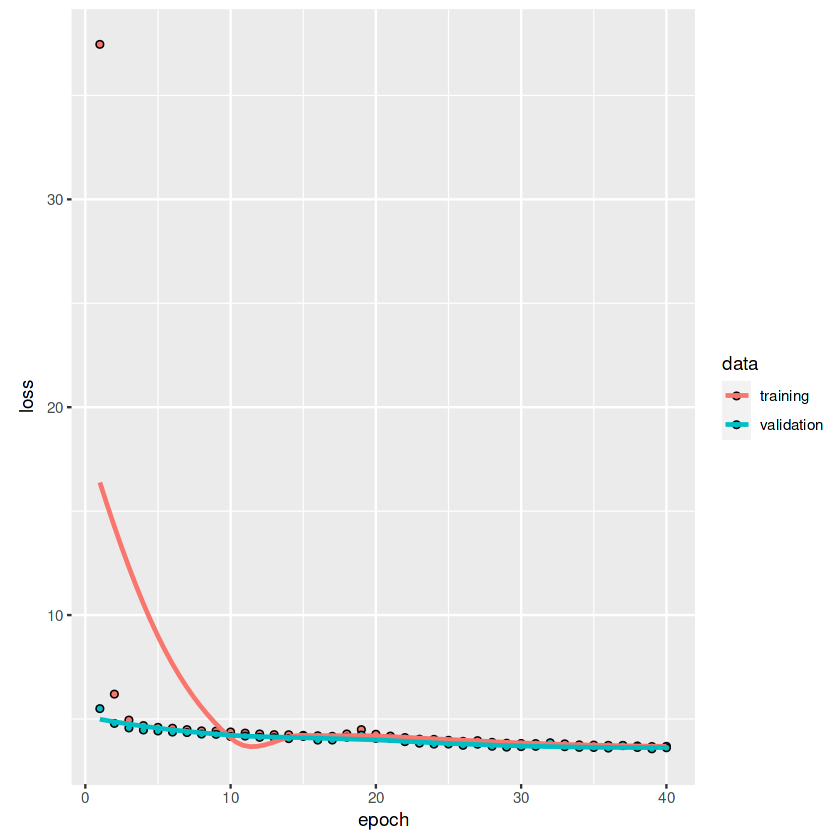

In [35]:
plot(history)

In [ ]:
#Prediction on the testset
#model_mean = keras_model(inputs=base$inputs, outputs=p_y$mean())
#model_sig = keras_model(inputs=base$inputs, outputs=p_y$stddev())

In [36]:
# Evaluation on the testset
res = model(X_test)
y_test_mean = res$mean()
y_test_std = res$stddev()
mean((y_test - as.numeric(y_test_mean))**2) #MSE on Testset 103.2168900245
evaluate(model,X_test, y_test)

[1] 122.9068

loss 
3.710705

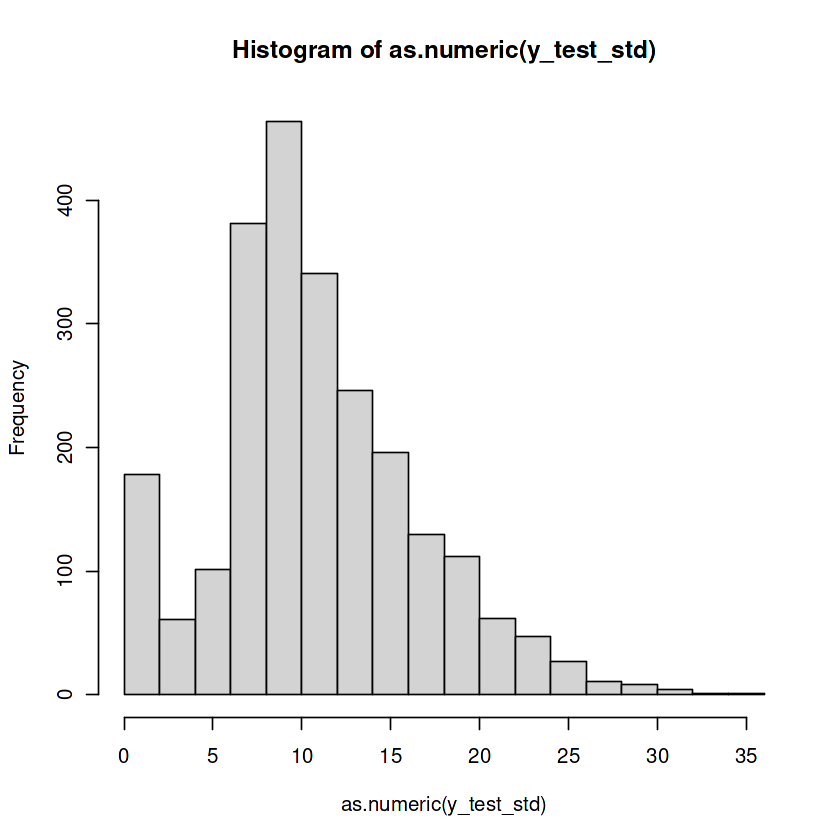

In [37]:
hist(as.numeric(y_test_std))

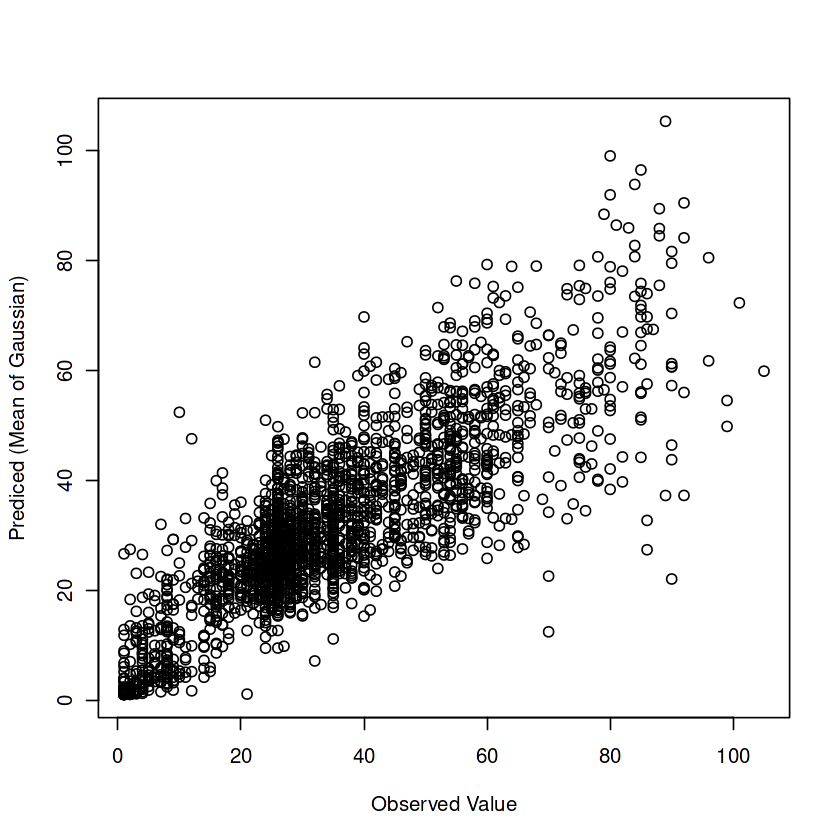

In [38]:
plot(y_test, y_test_mean, xlab = 'Observed Value', ylab='Prediced (Mean of Gaussian)')

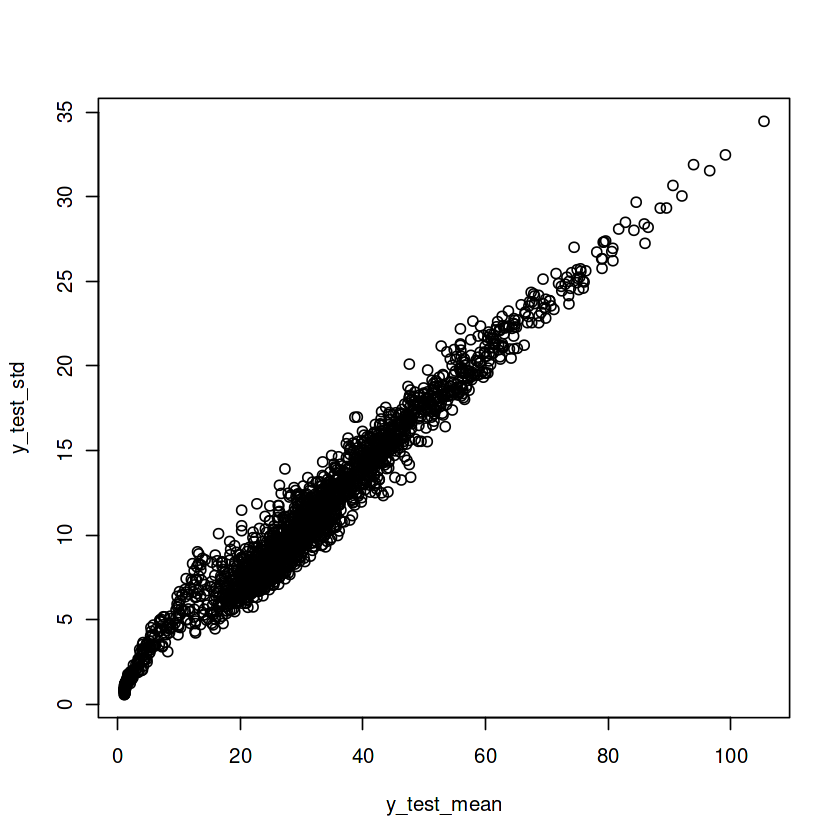

In [39]:
plot(y_test_mean, y_test_std)

In [41]:
#save_model_hdf5(model,'gaussian.h5') #not working can't pickle PyCapsule objects

# Additional Task

 <img src="https://raw.githubusercontent.com/tensorchiefs/dl_book/master/imgs/paper-pen.png" width="60" align="left" />  
*1. Use an image of the testset and plot the CPD

*2. Alternatively, you can use your own image(s) and estimate the age. The image must be align, you can do this with the following notebook:https://colab.research.google.com/drive/1z2tYIynyRubR2uNLTKTgAuAEqP8beybw?usp=sharing After aligning the images must be uploaded in a directory and you can use load_data from above.

In [50]:
str(X_test)

 num [1:2371, 1:64, 1:64, 1:3] 149 33 3 246 237 242 210 231 255 116 ...


[1] 16

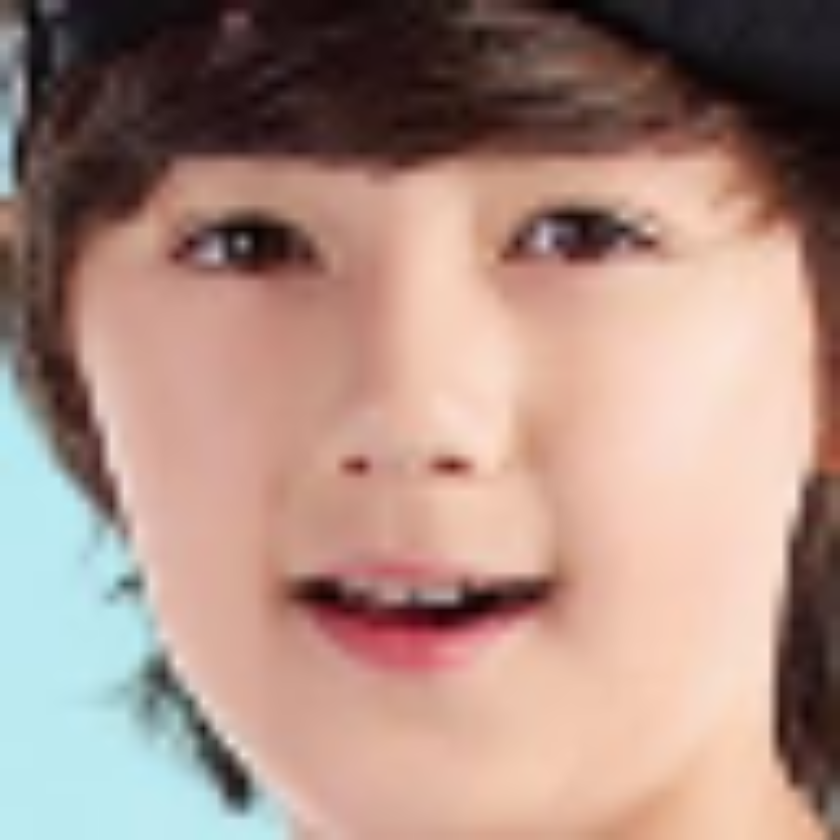

In [72]:
num = 200
grid.raster(X_test[num,,,]/255) #Check an image 
y_test[num]

In [73]:
res = model(X_test[200,1:64,1:64,1:3, drop=FALSE])
res$mean()
res$stddev()

tf.Tensor([[14.214917]], shape=(1, 1), dtype=float32)

tf.Tensor([[7.0770087]], shape=(1, 1), dtype=float32)

In [74]:
densities = as.numeric(exp(res$log_prob(1:100)))

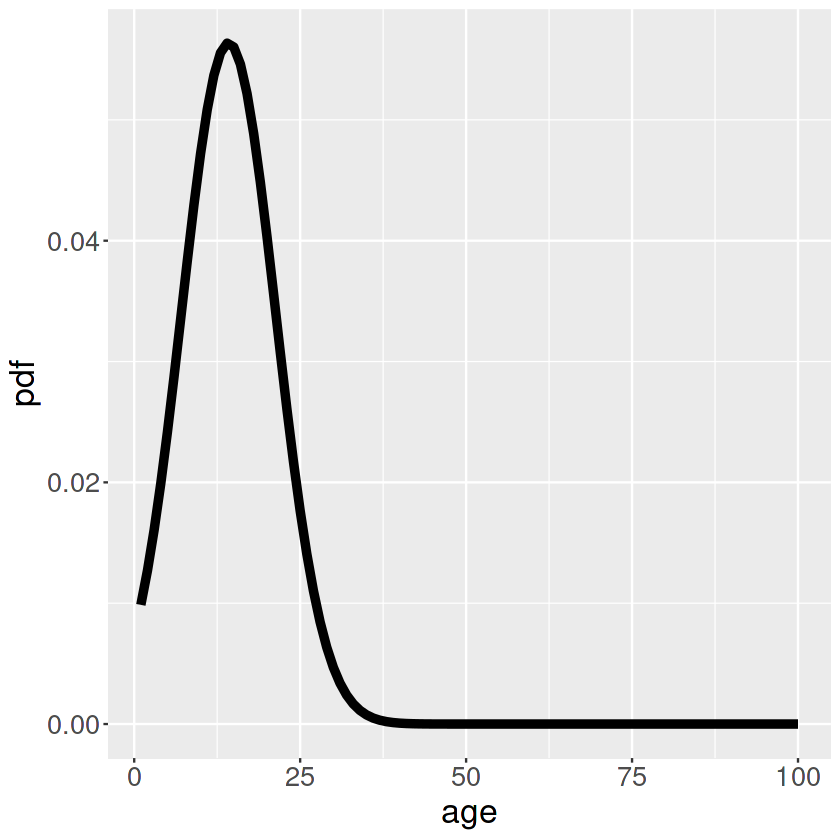

In [75]:
ggplot(data.frame(age=1:100, pdf=densities)) + geom_line(aes(x=age, y=pdf), size=2) + theme(text = element_text(size=20))